In [2]:
import pandas as pd 
import numpy as np 

import missingno as msn
from sklearn import metrics, neighbors, model_selection, preprocessing, pipeline, compose
from matplotlib import pyplot as plt 
import warnings

warnings.filterwarnings("ignore")

### Problem 1

#### 1. What to learn and predict?
##### Ans: Learning user transaction information, telco information and other relevant information and use this to predict a users repayment ability

### 2. What kind of file to create and submit to kaggle?
#### Ans: A csv file containing the user ID and probability of repayment 

### 3. What kind of index value will be used to evaluate submission?
#### Ans: Area under the ROC curve

### Base model

In [3]:
data = pd.read_csv("./data/application_train.csv")

data.head()

application = data.dropna(axis=0, how="any")


In [4]:
features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY']
target = ['TARGET']
application.drop([x for x in application.keys() if x not in features + target] , inplace=True, axis=1)

application.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY
71,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0
124,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5
152,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5
161,0,Cash loans,M,Y,N,0,162000.0,263686.5,24781.5
255,1,Cash loans,M,Y,N,1,225000.0,1019205.0,31032.0


In [5]:
categorical = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]
lb = preprocessing.LabelEncoder()
for category in categorical:
    application[category] = lb.fit_transform(application[category])

application.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY
71,0,0,1,0,1,0,103500.0,573628.5,24435.0
124,0,0,0,0,1,1,202500.0,260725.5,16789.5
152,0,0,0,0,0,0,202500.0,675000.0,53329.5
161,0,0,1,0,0,0,162000.0,263686.5,24781.5
255,1,0,1,0,0,1,225000.0,1019205.0,31032.0


Base ROC scrore: 0.5


Text(0, 0.5, 'Prediction')

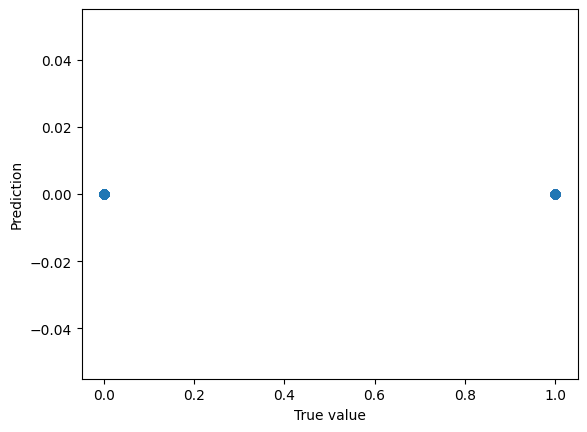

In [6]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(application[features], application[target], test_size=0.2, random_state=0)

y_train, y_test = np.ravel(y_train), np.ravel(y_test)

base_model = neighbors.KNeighborsClassifier(int(np.sqrt(len(x_train)))).fit(x_train, y_train)

base_prediction = base_model.predict(x_test)

base_score = metrics.roc_auc_score(y_test, base_prediction)

print(f"Base ROC scrore: {base_score}")


plt.scatter(y_test, base_prediction)
plt.xlabel("True value")
plt.ylabel("Prediction")

#### As indicated by the ROC score, the base model only correctly half of the time. 

### Problem 2

In [7]:
# Preprocessing, standardization and label encoding

def preprocessor(data):
    """
    Standardizes numerical data and encodes categorical data
    """

    #scaler and encoder
    scaler = preprocessing.StandardScaler()
    encoder = preprocessing.LabelEncoder()
    data = data.copy()

    for label in data.keys():
        dtype = data[label].dtype
        
        if dtype == "O":
           data[label] = encoder.fit_transform(data[label])
        """else:
            val = data[label].values
            data[label] =scaler.fit_transform([val]).reshape((-1, 1))
        """

    return data
       
            


In [8]:
credit_info = data.copy()

scaler = preprocessing.StandardScaler()
credit_info.drop(["SK_ID_CURR", "TARGET"], axis=1, inplace=True)


credit_info = pd.concat((preprocessor(credit_info), data["TARGET"]), axis=1)

credit_info.info(verbose=4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 121 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    NAME_CONTRACT_TYPE            int32  
 1    CODE_GENDER                   int32  
 2    FLAG_OWN_CAR                  int32  
 3    FLAG_OWN_REALTY               int32  
 4    CNT_CHILDREN                  int64  
 5    AMT_INCOME_TOTAL              float64
 6    AMT_CREDIT                    float64
 7    AMT_ANNUITY                   float64
 8    AMT_GOODS_PRICE               float64
 9    NAME_TYPE_SUITE               int32  
 10   NAME_INCOME_TYPE              int32  
 11   NAME_EDUCATION_TYPE           int32  
 12   NAME_FAMILY_STATUS            int32  
 13   NAME_HOUSING_TYPE             int32  
 14   REGION_POPULATION_RELATIVE    float64
 15   DAYS_BIRTH                    int64  
 16   DAYS_EMPLOYED                 int64  
 17   DAYS_REGISTRATION             float64
 18   DA

In [9]:
# select features with over 50% null values
thresh = 0.7

empty_features = credit_info.keys()[((credit_info.isna().sum() / len(credit_info) ) >= thresh).values]

#dropping unwated features
credit_info.drop(empty_features, axis=1, inplace=True)


<Axes: >

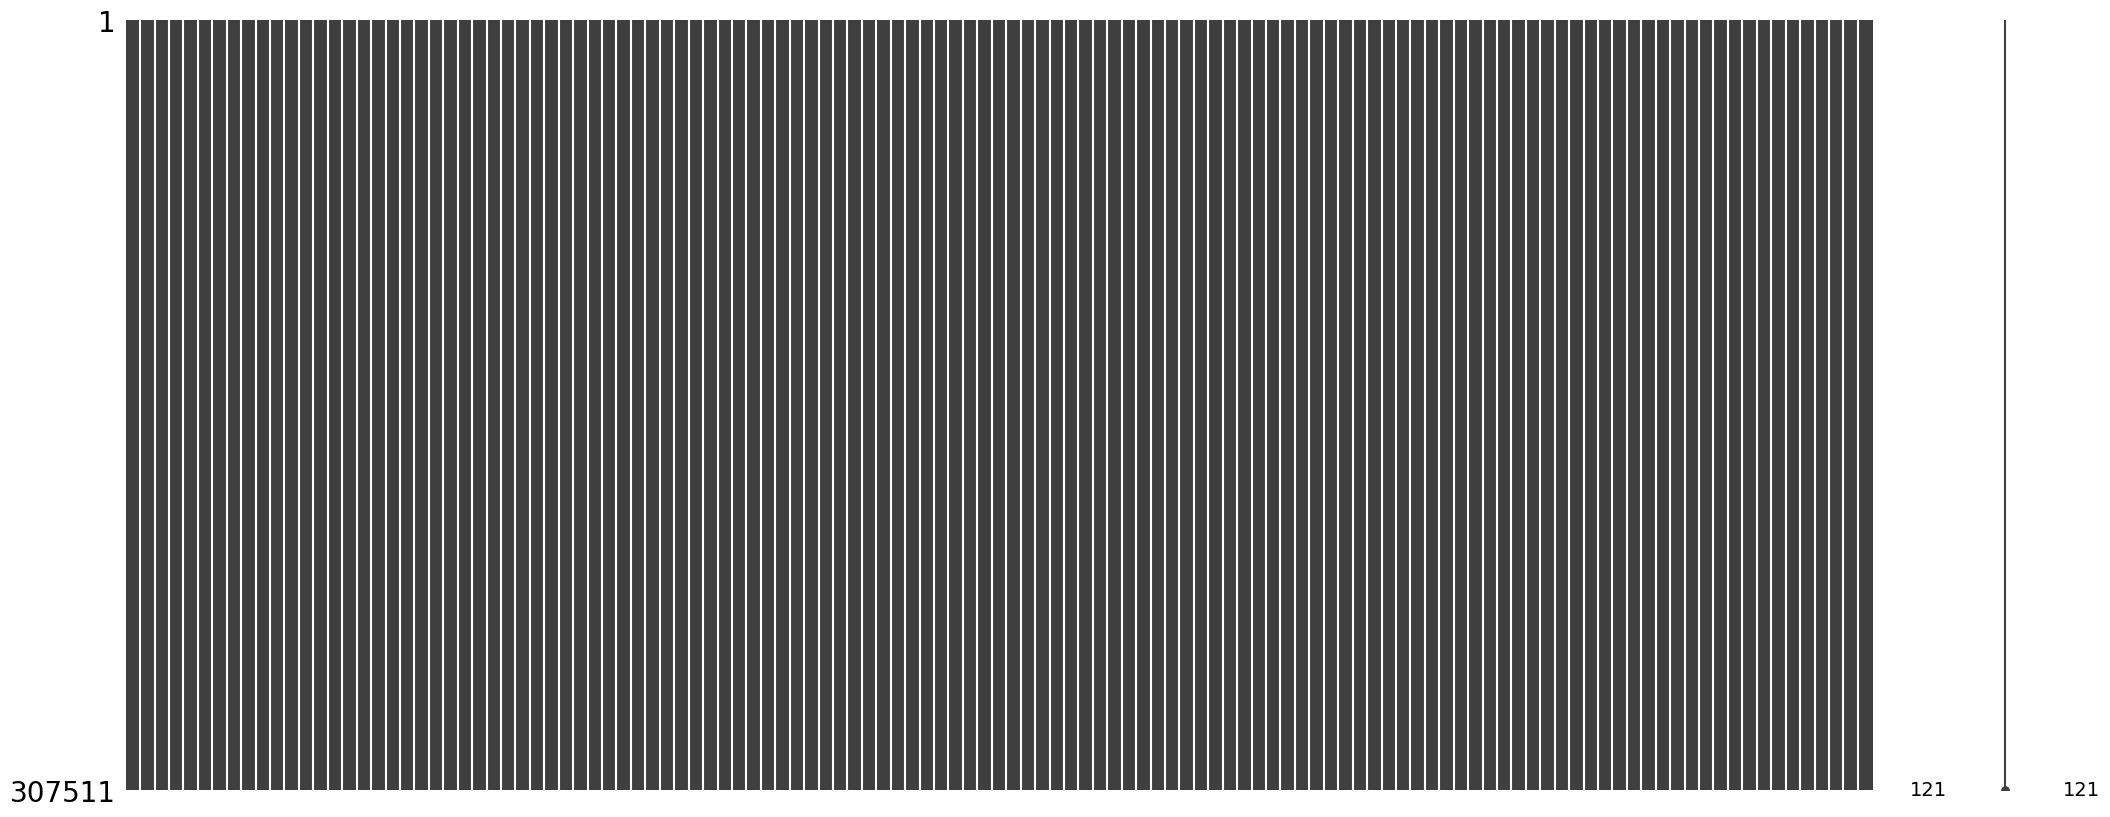

In [10]:
thresh = 0

null_features = credit_info.keys()[((credit_info.isna().sum() / len(credit_info) ) > thresh).values]

for feat in null_features:
    credit_info[feat].fillna(credit_info[feat].mean(), inplace =True)

msn.matrix(credit_info)

In [11]:
import seaborn as sns
# feature selection

#FEATURES THAT CORRELATE WITH TARGET VARIABLE
mat= credit_info.corr(numeric_only=True)

In [12]:
# extracting features with the best correlation with target variable
thresh = 0.05

potential_feat = (mat[(np.abs(mat) > thresh) & (np.abs(mat) < 1)]["TARGET"]).keys()

condition = (np.abs(mat["TARGET"]) > thresh) & ( np.abs(mat["TARGET"] )< 1)

interest_feat = potential_feat[condition]

In [13]:
#train test split and model training 


target = credit_info["TARGET"]

credit_info.drop([x for x in credit_info.keys() if x not in interest_feat], axis=1, inplace=True)

x_train, x_test, y_train, y_test = model_selection.train_test_split(credit_info, target, test_size=0.2, random_state=0)


In [14]:
model = neighbors.KNeighborsClassifier(algorithm="kd_tree", n_neighbors=11, p=1, weights="distance").fit(x_train, y_train)

prediction = model.predict(x_test)


In [15]:
metrics.roc_auc_score(y_test, prediction)

0.5019450921810895

In [16]:
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56648
           1       0.20      0.01      0.01      4855

    accuracy                           0.92     61503
   macro avg       0.56      0.50      0.48     61503
weighted avg       0.86      0.92      0.88     61503



In [17]:
metrics.confusion_matrix(y_test, prediction)

array([[56530,   118],
       [ 4826,    29]], dtype=int64)

In [27]:
test_data = pd.read_csv("./data/application_test.csv")

test_data["SK_ID_CURR"]

test_data = preprocessor(test_data)


test_data.dropna(axis=0, how="any", inplace=True)
id = test_data["SK_ID_CURR"]

test_data.drop([x for x in test_data.keys() if x not in interest_feat], axis=1, inplace=True)

In [60]:
predict = model.predict_proba(test_data)

x = np.vstack((id, predict[:, 0])).T

result = pd.DataFrame(x, columns=["ID", "Prob"])




(2396, 2)

In [61]:
result.to_csv("./data/result.csv")